In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorboard
tensorboard.__version__

from datetime import datetime
from packaging import version
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

# Загружаем необходимые файлы с данными

In [2]:
labels = pd.read_csv('./head_ct/labels.csv')
labels = np.array(labels[' hemorrhage'])
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [3]:
paths = sorted(glob('./head_ct/images/*.png'))
width = 128
height = 128
images = np.zeros((len(paths), height, width))

### Изменяем размер изображений на 128*128

In [4]:
for i, path in enumerate(paths):
  images[i] = cv2.resize(cv2.imread(path, 0), (width, height))
train_images, val_images, train_labels, val_labels = train_test_split(images, labels,test_size=0.2, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.5, random_state=1)
test_images_model = np.expand_dims(test_images, axis=3)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


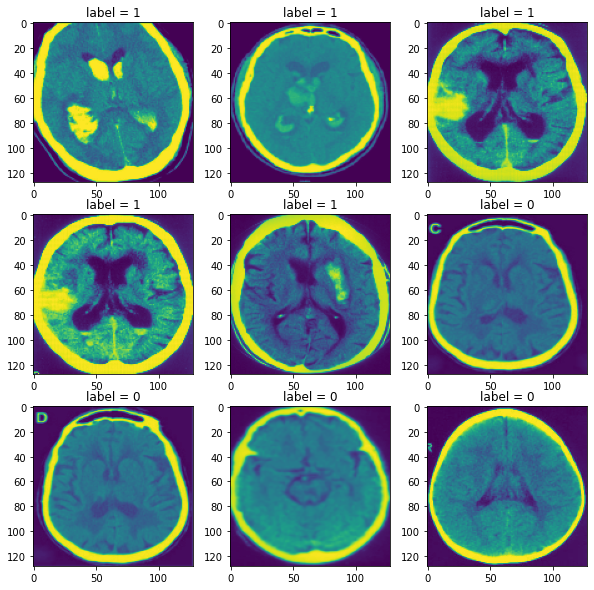

In [5]:
print(labels)
plt.figure(figsize=(10,10))
for i in range(0, 9):
  plt.subplot(3,3,i + 1)
  plt.imshow(images[i + 95])
  plt.title("label = {}".format(labels[i + 95]))
plt.show()

In [6]:
nb_train_samples = len(train_images)
nb_validation_samples = len(val_images)
print("train_images len = ", nb_train_samples, ", val_images len = ", nb_validation_samples)
epochs = 100
batch_size = 10


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(
    train_images[..., np.newaxis],
    train_labels,
    batch_size=batch_size)

validation_generator = val_datagen.flow(
    val_images[..., np.newaxis],
    val_labels,
    batch_size=batch_size)

train_images len =  160 , val_images len =  20


### Создаем модель

In [7]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128,128,1)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.5),

    layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.5),

    layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.Dropout(0.5),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(
    # optimizer=keras.optimizers.Adam(),
    optimizer=keras.optimizers.Adagrad(lr=0.075),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.001, patience=40, restore_best_weights=True)

In [9]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
16/16 [==============================] - 2s 100ms/step - loss: 0.8872 - binary_accuracy: 0.4938 - val_loss: 0.7267 - val_binary_accuracy: 0.3500
Epoch 2/100
16/16 [==============================] - 1s 89ms/step - loss: 0.6967 - binary_accuracy: 0.5000 - val_loss: 0.6991 - val_binary_accuracy: 0.3500
Epoch 3/100
16/16 [==============================] - 1s 91ms/step - loss: 0.6901 - binary_accuracy: 0.5562 - val_loss: 0.6959 - val_binary_accuracy: 0.3500
Epoch 4/100
16/16 [==============================] - 1s 92ms/step - loss: 0.6890 - binary_accuracy: 0.5875 - val_loss: 0.6971 - val_binary_accuracy: 0.4000
Epoch 5/100
16/16 [==============================] - 1s 92ms/step - loss: 0.6482 - binary_accuracy: 0.7063 - val_loss: 0.6290 - val_binary_accuracy: 0.6500
Epoch 6/100
16/16 [==============================] - 1s 92ms/step - loss: 0.6941 - binary_accuracy: 0.6500 - val_loss: 0.7018 - val_binary_accu

16/16 [==============================] - 1s 86ms/step - loss: 0.3507 - binary_accuracy: 0.8813 - val_loss: 0.5543 - val_binary_accuracy: 0.6500
Epoch 52/100
16/16 [==============================] - 1s 85ms/step - loss: 0.3733 - binary_accuracy: 0.8438 - val_loss: 0.5543 - val_binary_accuracy: 0.6500
Epoch 53/100
16/16 [==============================] - 1s 85ms/step - loss: 0.3527 - binary_accuracy: 0.8500 - val_loss: 0.9448 - val_binary_accuracy: 0.5500
Epoch 54/100
16/16 [==============================] - 1s 84ms/step - loss: 0.3517 - binary_accuracy: 0.8750 - val_loss: 0.7755 - val_binary_accuracy: 0.5000
Epoch 55/100
16/16 [==============================] - 1s 86ms/step - loss: 0.2997 - binary_accuracy: 0.9000 - val_loss: 0.4705 - val_binary_accuracy: 0.7500
Epoch 56/100
16/16 [==============================] - 1s 85ms/step - loss: 0.3317 - binary_accuracy: 0.8687 - val_loss: 0.6769 - val_binary_accuracy: 0.6000
Epoch 57/100
16/16 [==============================] - 1s 85ms/step - lo

<AxesSubplot:title={'center':'Зависимость точности от эпохи'}, xlabel='Эпоха', ylabel='Точность'>

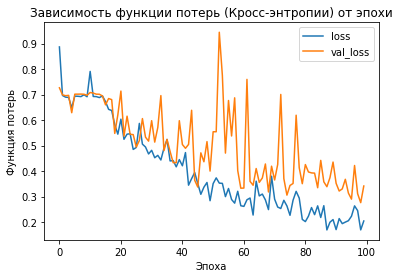

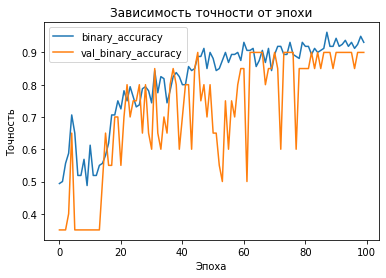

In [10]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Зависимость функции потерь (Кросс-энтропии) от эпохи", xlabel='Эпоха', ylabel='Функция потерь')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Зависимость точности от эпохи", xlabel='Эпоха', ylabel='Точность')

In [11]:
test_preds = model.predict(test_images_model)
test_preds_int = [int(i) for i in test_preds]
print(test_preds)
print(test_preds_int)

[[0.72392076]
 [0.9999999 ]
 [0.30499095]
 [0.7415676 ]
 [0.53858894]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.95996237]
 [0.9847424 ]
 [1.        ]
 [0.91718394]
 [1.        ]
 [0.00271958]
 [0.00613007]
 [1.        ]
 [0.9621098 ]
 [1.        ]
 [0.9974357 ]
 [0.3020354 ]]
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


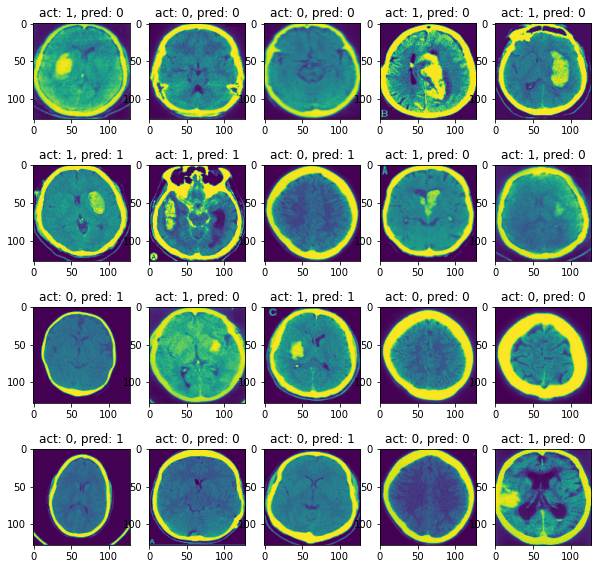

In [12]:
plt.figure(figsize=(10,10))
for i in range(0, 20):
  plt.subplot(4,5,i+1)
  plt.imshow(test_images[i])
  plt.title("act: {}, pred: {}".format(test_labels[i],test_preds_int[i]))
plt.show()

In [13]:
from tensorflow import metrics
lst = test_labels == test_preds_int
acc = np.count_nonzero(lst == True) / lst.size
print("Точность модели на тестовых данных = {}".format(acc))

Точность модели на тестовых данных = 0.45
